<a href="https://colab.research.google.com/github/bizkid123/geolocation/blob/main/geolocation_train_vit_with_aug_20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!apt install unzip

Reading package lists... Done
Building dependency tree       
Reading state information... Done
unzip is already the newest version (6.0-25ubuntu1.1).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.


In [ ]:
!pip install albumentations

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached wandb-0.15.1-py3-none-any.whl (2.0 MB)
  Using cached GitPython-3.1.31-py3-none-any.whl (184 kB)
  Using cached docker_pycreds-0.4.0-py2.py3-none-any.whl (9.0 kB)
  Using cached setproctitle-1.3.2-cp310-cp310-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl (30 kB)
  Using cached pathtools-0.1.2.tar.gz (11 kB)
  Preparing metadata (setup.py) ... done
  Using cached sentry_sdk-1.21.1-py2.py3-none-any.whl (201 kB)
  Using cached gitdb-4.0.10-py3-none-any.whl (62 kB)
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8807 sha256=8fd1db21a31706d9ed60a4245ac87a0e8308bb3e13f12adcd9951a8192b28659
  Stored in directory: /root/.cache/pip/wheels/e7/f3/22/152153d6eb222ee7a56ff8617d80ee5207207a8c00a7aab794
Successfully built pathtools


In [ ]:
!pip install timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install open_clip_torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
import timm

In [ ]:
import wandb
import torchvision as tv
import fastai
from fastai.vision.all import *
from fastai.callback.wandb import WandbCallback
import open_clip


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!unzip -qq '/content/drive/My Drive/Geolocation/50States10K.zip' -d '/content/geolocation'

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
config = SimpleNamespace(
    batch_size=32,
    img_size=224,
    seed=42,
    pretrained=True,
    normalize=True,
    model_name="vit_small_patch32_224",
    epochs=20,                                 # FIX THIS LATER
    learning_rate=2e-3,
    resize="crop",
)

In [ ]:
import albumentations as A
import PIL

def albumentations_transforms(x: PIL.Image.Image, img_size=224):
    transforms = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.ImageCompression(quality_lower=99, quality_upper=100),
        A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=10, border_mode=0, p=0.7),
        A.Resize(img_size, img_size),
        A.Cutout(max_h_size=int(img_size * 0.4), max_w_size=int(img_size * 0.4), num_holes=1, p=0.5),
    ])
    
    return PIL.Image.fromarray(transforms(image=np.array(x))["image"])

In [ ]:
def load_data():
  resize_method = ResizeMethod.Squish if config.resize == "squish" else ResizeMethod.Crop
  dls = fastai.vision.data.ImageDataLoaders.from_folder(
    '/content/geolocation',
    valid_pct=0.05,
    seed=config.seed,
    bs=config.batch_size,
    item_tfms=[Resize(config.img_size, method = resize_method), albumentations_transforms]
  )


  mean, std = (0.48145466, 0.4578275, 0.40821073), (
      0.26862954,
      0.26130258,
      0.27577711,
  )

  if config.normalize:
      dls.add_tfms([Normalize.from_stats(mean, std)], "after_batch")

  return dls

dls = load_data()
print("Num classes =", dls.c)
print(len(dls.train_ds), len(dls.valid_ds))


/usr/local/lib/python3.10/dist-packages/albumentations/augmentations/dropout/cutout.py:50: FutureWarning: Cutout has been deprecated. Please use CoarseDropout
  warnings.warn(


Num classes = 50
475026 25001


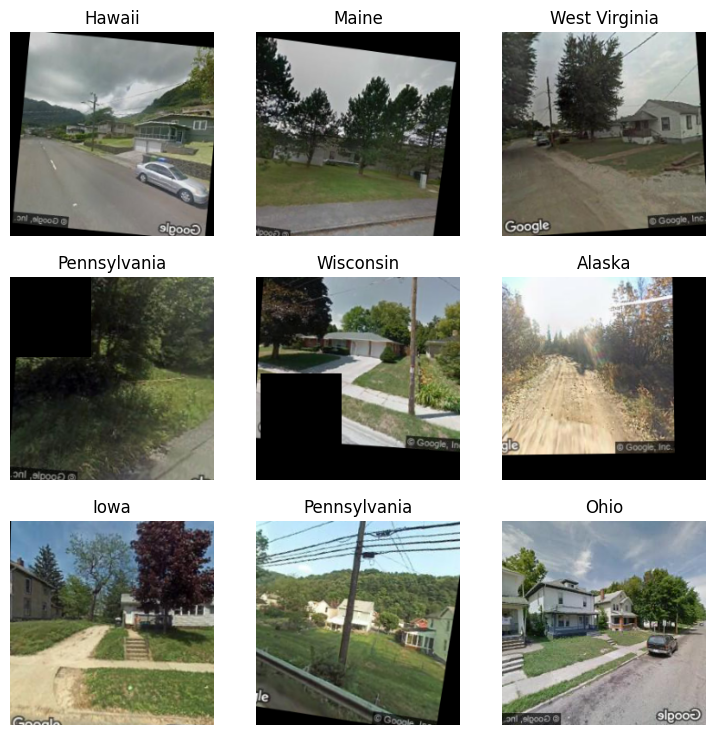

In [ ]:
dls.show_batch()

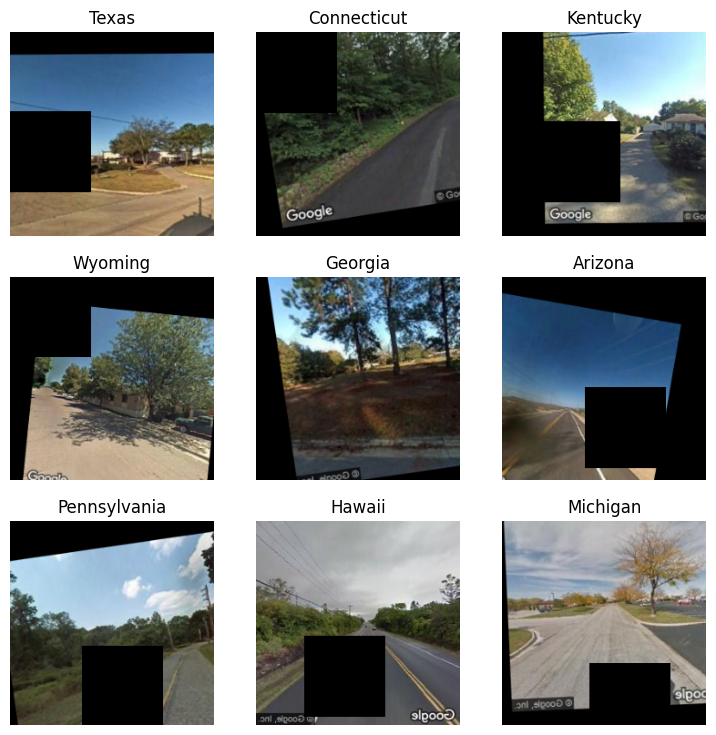

In [ ]:
dls.show_batch()

In [ ]:
# callback = WandbCallback(log_preds=True, log_preds_every_epoch=True, log_model=True)
from fastai.callback.wandb import log_model
def new_after_epoch(self):
  "Log validation loss and custom metrics & log prediction samples"
  # Correct any epoch rounding error and overwrite value
  self._wandb_epoch = round(self._wandb_epoch)
  if self.log_preds and self.log_preds_every_epoch:
      self.log_predictions()
  wandb.log({'epoch': self._wandb_epoch}, step=self._wandb_step)
  wandb.log({n:s for n,s in zip(self.recorder.metric_names, self.recorder.log) if n not in ['train_loss', 'epoch', 'time']}, step=self._wandb_step)


  name = f"{learn.cbs[-2].fname}_epoch_{self._wandb_epoch}"
  learn.save(name, with_opt=True)
  # metadata = {n:s for n,s in zip(self.recorder.metric_names, self.recorder.log) if n not in ['train_loss', 'epoch', 'time']}
  # log_model(self.save_model.last_saved_path, name=self.save_model.fname, metadata=metadata) 
  # log_model(f"{name}.pth", name=self.save_model.fname+self._wandb_epoch, metadata=metadata)     



WandbCallback.after_epoch = new_after_epoch

In [ ]:
train_cbs = [
    WandbCallback(log_preds=True, log_preds_every_epoch=True, log_model=True),
]

other_cbs = [
]

top_2_accuracy = functools.partial(top_k_accuracy, k=2)
top_3_accuracy = functools.partial(top_k_accuracy, k=3)
top_5_accuracy = functools.partial(top_k_accuracy, k=5)
top_10_accuracy = functools.partial(top_k_accuracy, k=10)

learn = vision_learner(
    dls,
    config.model_name,
    metrics=[accuracy, top_2_accuracy, top_3_accuracy, top_5_accuracy, top_10_accuracy],
    # metrics=[accuracy, top_2_accuracy, top_3_accuracy],
    concat_pool=True,
    cbs=train_cbs
).to_fp16()

learn.model.to(device)
None

In [ ]:
# learn.cbs[-2].fname

In [ ]:
def wandb_init():
    wandb.login()

wandb_init()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
"""path='/content/geolocation/models/model.pth'
path = Path(path)
if not path.is_file():
    raise f'path must be a valid file: {path}'
name = None
name = ifnone(name, f'run-{wandb.run.id}-model')
_format_metadata(metadata)    
artifact_model = wandb.Artifact(name=name, type='model', metadata=metadata, description=description)
with artifact_model.new_file(str(Path(name).with_suffix(".pth")), mode='wb') as fa:
    fa.write(path.read_bytes())
wandb.run.log_artifact(artifact_model)
"""

'path=\'/content/geolocation/models/model.pth\'\npath = Path(path)\nif not path.is_file():\n    raise f\'path must be a valid file: {path}\'\nname = None\nname = ifnone(name, f\'run-{wandb.run.id}-model\')\n_format_metadata(metadata)    \nartifact_model = wandb.Artifact(name=name, type=\'model\', metadata=metadata, description=description)\nwith artifact_model.new_file(str(Path(name).with_suffix(".pth")), mode=\'wb\') as fa:\n    fa.write(path.read_bytes())\nwandb.run.log_artifact(artifact_model)\n'

wandb: Currently logged in as: ben_z. Use `wandb login --relogin` to force relogin


Finding optimal learning rate


Creating learner for vit_small_patch32_224
Learning rate = 0.00363078061491251


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,top_k_accuracy,top_k_accuracy,top_k_accuracy,time
0,2.905708,2.738646,0.252830,0.376545,0.459702,0.574337,0.747650,12:16


Better model found at epoch 0 with valid_loss value: 2.7386460304260254.


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,top_k_accuracy,top_k_accuracy,top_k_accuracy,time
0,2.459488,2.352676,0.339986,0.478621,0.566297,0.684333,0.833087,17:02
1,2.353813,2.192957,0.379465,0.519899,0.609016,0.718811,0.857966,17:12
2,2.238263,2.069648,0.407304,0.550858,0.636455,0.747290,0.877245,17:22
3,2.140921,1.984587,0.425863,0.572097,0.660174,0.767209,0.888404,17:39
4,2.035386,1.896614,0.451622,0.598096,0.682693,0.784649,0.898284,17:35
5,1.866727,1.840967,0.466301,0.613495,0.697532,0.798528,0.903604,17:45
6,1.778275,1.753461,0.489500,0.633535,0.720291,0.813327,0.913323,17:40
7,1.713995,1.674486,0.510860,0.656654,0.736691,0.826127,0.920803,17:39
8,1.619813,1.618879,0.526019,0.667773,0.748290,0.836247,0.926723,17:35
9,1.623111,1.575657,0.539938,0.681453,0.757890,0.843126,0.930763,17:46


Better model found at epoch 0 with valid_loss value: 2.3526763916015625.
Better model found at epoch 1 with valid_loss value: 2.1929569244384766.
Better model found at epoch 2 with valid_loss value: 2.069648027420044.
Better model found at epoch 3 with valid_loss value: 1.9845868349075317.
Better model found at epoch 4 with valid_loss value: 1.8966143131256104.
Better model found at epoch 5 with valid_loss value: 1.8409667015075684.
Better model found at epoch 6 with valid_loss value: 1.7534610033035278.
Better model found at epoch 7 with valid_loss value: 1.6744863986968994.
Better model found at epoch 8 with valid_loss value: 1.618878960609436.
Better model found at epoch 9 with valid_loss value: 1.575656533241272.
Better model found at epoch 10 with valid_loss value: 1.5254930257797241.
Better model found at epoch 11 with valid_loss value: 1.480247974395752.
Better model found at epoch 12 with valid_loss value: 1.4341518878936768.
Better model found at epoch 13 with valid_loss value

accuracy,▁▃▃▄▄▅▅▆▆▆▆▇▇▇▇▇█████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eps_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_0,▃█▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_1,▃█▂▂▃▃▄▄▅▆▆▇▇▇▇▇▇▆▆▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
mom_0,▇▄██▇▇▆▅▄▃▂▁▁▁▁▁▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇█████
mom_1,▇▄██▇▇▆▅▄▃▂▁▁▁▁▁▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇█████
raw_loss,█▆▇▆▅▅▆▅▅▅▃▄▅▄▅▄▄▃▄▄▃▂▂▁▃▂▂▂▄▂▃▂▂▁▃▂▁▁▁▁
sqr_mom_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
sqr_mom_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


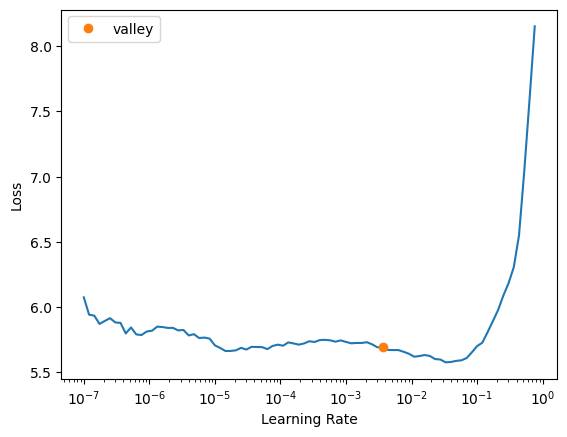

In [ ]:
with wandb.init(config=config, project="geolocation"):
    # log_model('model.pth')
    print(f"Finding optimal learning rate")
    lrs = learn.lr_find()
    # lr = 0.002511886414140463
    lr = lrs.valley

    print(f"Creating learner for {config.model_name}")
    print(f"Learning rate = {lr}")
    ti = time.perf_counter()
    learn.fine_tune(base_lr=lr, epochs=config.epochs)
    wandb.summary["fit_time"] = time.perf_counter() - ti

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

ValueError: ignored

In [ ]:
learn.dls.c

In [ ]:
interp.plot_top_losses(10)

In [ ]:
interp.plot_confusion_matrix(figsize=(15,15), dpi=60)